# 7 ベイズA/Bテスト
## 7.2 コンバージョンテストの復習

In [1]:
using Distributed
addprocs(3)

@everywhere using Mamba

In [2]:
using Distributions
using Plots
using Printf

In [3]:
visitors_to_A = 1300
visitors_to_B = 1275

convertions_from_A = 120
convertions_from_B = 125

125

In [4]:
alpha_prior = 1
beta_prior = 1

posterior_A = Beta(alpha_prior + convertions_from_A, beta_prior + visitors_to_A - convertions_from_A)
posterior_B = Beta(alpha_prior + convertions_from_B, beta_prior + visitors_to_B - convertions_from_B)

Beta{Float64}(α=126.0, β=1151.0)

In [5]:
samples = 20000
samples_posterior_A = rand(posterior_A, samples)
samples_posterior_B = rand(posterior_B, samples)

mean(samples_posterior_A .> samples_posterior_B)

0.3067

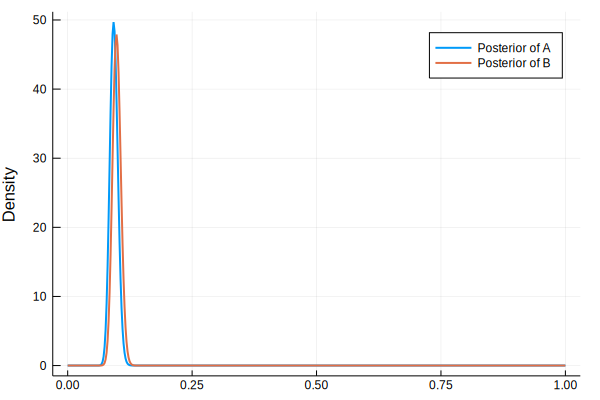

In [30]:
x = range(0, stop = 1, length = 500)
Plots.plot(x, pdf.(posterior_A, x), linewidth = 2, label = "Posterior of A", ylabel = "Density")
Plots.plot!(x, pdf.(posterior_B, x), linewidth = 2, label = "Posterior of B")

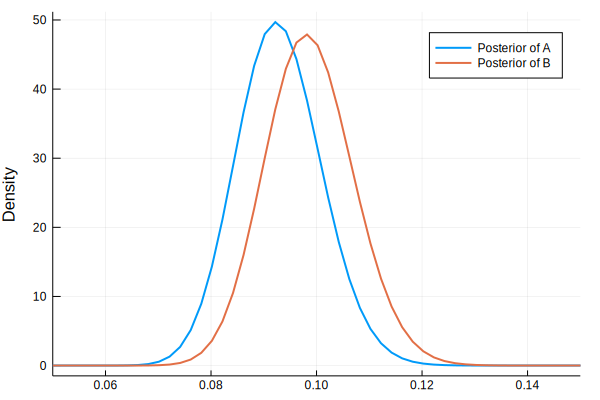

In [32]:
Plots.plot(x, pdf.(posterior_A, x), linewidth = 2, label = "Posterior of A", ylabel = "Density", xlims = (0.05, 0.15))
Plots.plot!(x, pdf.(posterior_B, x), linewidth = 2, label = "Posterior of B")

## 7.3 線形損失関数の追加
### 7.3.1 期待収益の解析

In [8]:
P = [0.5, 0.2, 0.3]
N = 1
rand(Multinomial(N, P))

3-element Array{Int64,1}:
 1
 0
 0

In [9]:
N = 10
rand(Multinomial(N, P))

3-element Array{Int64,1}:
 5
 3
 2

In [10]:
sample = rand(Dirichlet([1, 1]))
println(sample)
println(sum(sample))

[0.869351, 0.130649]
1.0


In [11]:
sample = rand(Dirichlet([1, 1, 1, 1]))
println(sample)
println(sum(sample))

[0.153891, 0.442386, 0.216572, 0.187151]
1.0


In [12]:
N = 1000
N_79 = 10
N_49 = 46
N_25 = 80
N_0 = N - (N_79 + N_49 + N_25)

obs = [N_79, N_49, N_25, N_0]
prior_parameters = [1, 1, 1, 1]
posterior_samples = rand(Dirichlet(prior_parameters + obs), 10000)
println(posterior_samples[:, 1])
println(posterior_samples[:, 2])

[0.0109812, 0.0386507, 0.0735051, 0.876863]
[0.0121947, 0.0437036, 0.0782981, 0.865804]


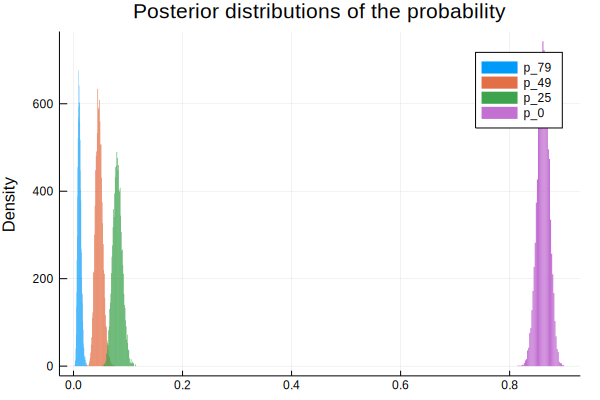

In [33]:
plt = Plots.plot(ylabel = "Density", title = "Posterior distributions of the probability")
for (i, label) in enumerate(["p_79", "p_49", "p_25", "p_0"])
     histogram!(posterior_samples[i, :], linewidth = 0, label = label)
end
plt

In [14]:
function expected_revenue(P)
    @.(79 * P[1, :] + 49 * P[2, :] + 25 * P[3, :] + 0 * P[4, :])
end

expected_revenue (generic function with 1 method)

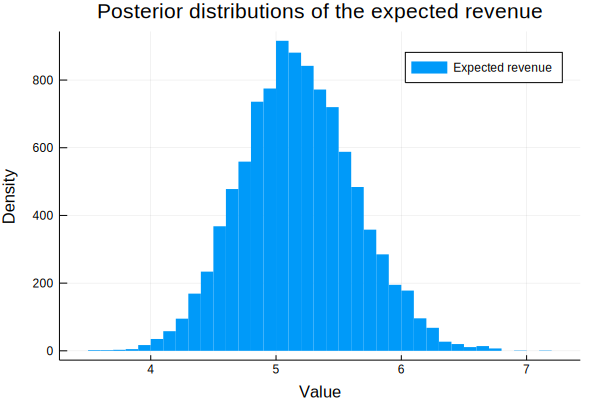

In [15]:
posterior_expected_revenue = expected_revenue(posterior_samples)
histogram(posterior_expected_revenue, xlabel = "Value", ylabel = "Density", 
    linewidth = 0,
    title = "Posterior distributions of the expected revenue",
    label = "Expected revenue")

### 7.3.2 A/Bテストへと拡張する

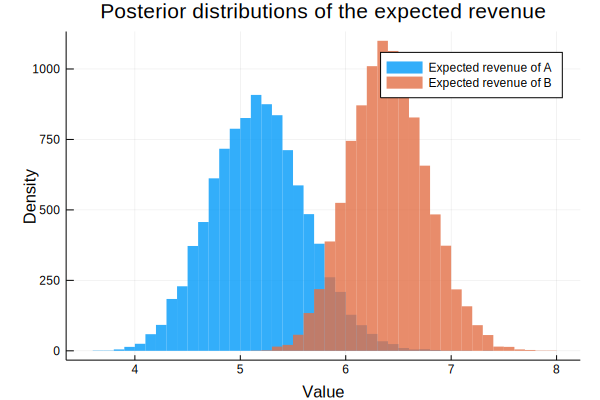

In [16]:
N_A = 1000
N_A_79 = 10
N_A_49 = 46
N_A_25 = 80
N_A_0 = N_A - (N_A_79 + N_A_49 + N_A_25)
obs_A = [N_A_79, N_A_49, N_A_25, N_A_0]

N_B = 2000
N_B_79 = 45
N_B_49 = 84
N_B_25 = 200
N_B_0 = N_B - (N_B_79 + N_B_49 + N_B_25)
obs_B = [N_B_79, N_B_49, N_B_25, N_B_0]

prior_parameters = [1, 1, 1, 1]
posterior_samples_A = rand(Dirichlet(prior_parameters + obs_A), 10000)
posterior_samples_B = rand(Dirichlet(prior_parameters + obs_B), 10000)

posterior_expected_revenue_A = expected_revenue(posterior_samples_A)
posterior_expected_revenue_B = expected_revenue(posterior_samples_B)

histogram(posterior_expected_revenue_A, xlabel = "Value", ylabel = "Density", 
    bins = 50, linewidth = 0, fillalpha = 0.8,
    title = "Posterior distributions of the expected revenue",
    label = "Expected revenue of A")
histogram!(posterior_expected_revenue_B,
    bins = 50, linewidth = 0, fillalpha = 0.8,
    label = "Expected revenue of B")

In [17]:
p = mean(posterior_expected_revenue_B .> posterior_expected_revenue_A)
println(@sprintf("Probability that page B has a higher revenue than page A: %.3f", p))

Probability that page B has a higher revenue than page A: 0.981


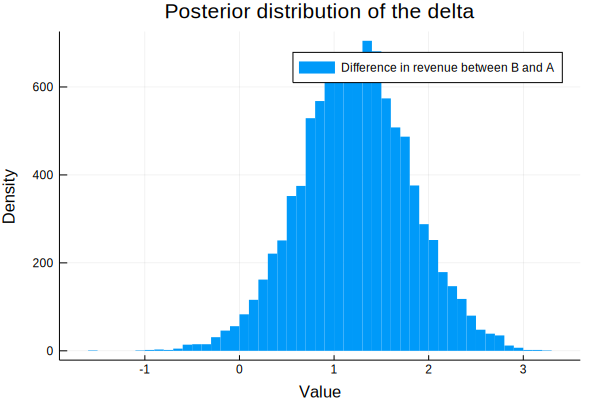

In [103]:
posterior_diff = posterior_expected_revenue_B - posterior_expected_revenue_A
histogram(posterior_diff, bins = 50, linewidth = 0,
    xlabel = "Value", ylabel = "Density",
    label = "Difference in revenue between B and A",
    title = "Posterior distribution of the delta")

## 7.4 コンバージョン以上の情報を得るために: t検定
### 7.4.1 t検定の手順

In [19]:
N = 250
mu_A, std_A = 30, 4
mu_B, std_B = 25, 7

duration_A = rand(Normal(mu_A, std_A), N)
duration_B = rand(Normal(mu_B, std_B), N)

println(duration_A[1:8])
println(duration_B[1:8])

pooled_mean = mean([duration_A; duration_B])
pooled_std = std([duration_A; duration_B])

[29.1114, 36.9635, 28.6907, 31.8109, 24.1171, 28.073, 31.2818, 33.8462]
[9.4486, 36.129, 26.2577, 34.7581, 15.8491, 22.1826, 19.1187, 14.1]


6.272724125640302

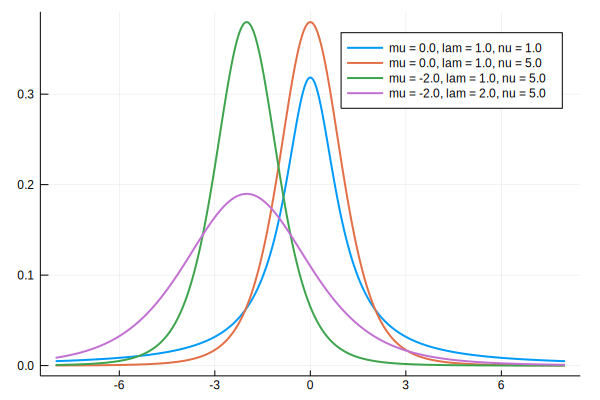

In [34]:
# StudentT分布のシフト
x = -8:0.01:8
mu = [0, 0, -2, -2]
lam = [1, 1, 1, 2]
nu = [1, 5, 5, 5]
plt = Plots.plot()

for i in 1:4
    y = pdf.(LocationScale(mu[i], lam[i], TDist(nu[i])), x)
    Plots.plot!(x, y, linewidth = 2,
        label = @sprintf("mu = %.1f, lam = %.1f, nu = %.1f", mu[i], lam[i], nu[i]))
end
plt

In [21]:
# Distribution.jlでは標準偏差を使う(PyMCとは違うところ)

model = Model(
    obs_A = Stochastic(1, 
        (mu_A, std_A, nu_minus_1) -> LocationScale(mu_A, std_A, TDist(nu_minus_1 + 1)),
        false
    ),
    
    obs_B = Stochastic(1, 
        (mu_B, std_B, nu_minus_1) -> LocationScale(mu_B, std_B, TDist(nu_minus_1 + 1)),
        false
    ),
    
    mu_A = Stochastic(
        (pooled_mean, pooled_std) -> Normal(pooled_mean, pooled_std * 1000)
    ),
    
    mu_B = Stochastic(
        (pooled_mean, pooled_std) -> Normal(pooled_mean, pooled_std * 1000)
    ),
    
    std_A = Stochastic(
        pooled_std -> Uniform(pooled_std / 1000, pooled_std * 1000)
    ),
    
    std_B = Stochastic(
        pooled_std -> Uniform(pooled_std / 1000, pooled_std * 1000)
    ),
    
    nu_minus_1 = Stochastic(
        () -> Exponential(1. / 29.)
    )
    
)

Object of type "Model"
-------------------------------------------------------------------------------
obs_A:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
mu_B:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
std_B:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
mu_A:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
obs_B:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
std_A:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
nu_minus_1:
A monitored node of type "ScalarSto

In [22]:
data = Dict{Symbol, Any}(
    :obs_A => duration_A,
    :obs_B => duration_B,
    :pooled_mean => pooled_mean,
    :pooled_std => pooled_std,
)

Dict{Symbol,Any} with 4 entries:
  :obs_A       => [29.1114, 36.9635, 28.6907, 31.8109, 24.1171, 28.073, 31.2818…
  :pooled_mean => 27.3808
  :obs_B       => [9.4486, 36.129, 26.2577, 34.7581, 15.8491, 22.1826, 19.1187,…
  :pooled_std  => 6.27272

In [23]:
inits = [
    Dict(
        :obs_A => duration_A,
        :obs_B => duration_B,
        :mu_A => pooled_mean,
        :mu_B => pooled_mean,
        :std_A => pooled_std,
        :std_B => pooled_std,
        :nu_minus_1 => 1,
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:obs_A=>[29.1114, 36.9635, 28.6907, 31.8109, 24.1171, 28.073, 31.2818, 33.8462, 30.0716, 34.5186  …  28.7239, 18.2658, 33.0471, 31.0471, 28.6865, 29.8915, 23.4363, 33.1877, 33.6889, 27.3629],:mu_B=>27.3808,:std_B=>6.27272,:mu_A=>27.3808,:obs_B=>[9.4486, 36.129, 26.2577, 34.7581, 15.8491, 22.1826, 19.1187, 14.1, 18.826, 29.9892  …  7.96595, 27.8582, 23.5454, 24.8633, 23.7419, 16.635, 23.364, 33.3984, 24.3231, 34.6569],:std_A=>6.27272,:nu_minus_1=>1)
 Dict(:obs_A=>[29.1114, 36.9635, 28.6907, 31.8109, 24.1171, 28.073, 31.2818, 33.8462, 30.0716, 34.5186  …  28.7239, 18.2658, 33.0471, 31.0471, 28.6865, 29.8915, 23.4363, 33.1877, 33.6889, 27.3629],:mu_B=>27.3808,:std_B=>6.27272,:mu_A=>27.3808,:obs_B=>[9.4486, 36.129, 26.2577, 34.7581, 15.8491, 22.1826, 19.1187, 14.1, 18.826, 29.9892  …  7.96595, 27.8582, 23.5454, 24.8633, 23.7419, 16.635, 23.364, 33.3984, 24.3231, 34.6569],:std_A=>6.27272,:nu_minus_1=>1)
 Dict(:obs_A=>[29.1114, 36.9635, 28.6907, 31.

In [70]:
scheme = [AMWG([:mu_A, :mu_B, :std_A, :std_B], 0.1), AMWG([:nu_minus_1], 10)]

2-element Array{Sampler{Mamba.AMWGTune},1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:mu_A, :mu_B, :std_A, :std_B]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:nu_minus_1]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 10), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple

In [71]:
setsamplers!(model, scheme)
sim = mcmc(model, data, inits, 25000, burnin = 10000, thin = 2, chains = 3)

MCMC Simulation of 25000 Iterations x 3 Chains...

      From worker 3:	Chain 3:   0% [0:12:43 of 0:12:43 remaining]
      From worker 2:	Chain 1:   0% [0:12:04 of 0:12:04 remaining]
      From worker 4:	Chain 2:   0% [0:12:22 of 0:12:22 remaining]
      From worker 4:	Chain 2:  10% [0:00:42 of 0:00:47 remaining]
      From worker 2:	Chain 1:  10% [0:00:43 of 0:00:47 remaining]
      From worker 3:	Chain 3:  10% [0:00:44 of 0:00:49 remaining]
      From worker 2:	Chain 1:  20% [0:00:36 of 0:00:45 remaining]
      From worker 4:	Chain 2:  20% [0:00:36 of 0:00:45 remaining]
      From worker 3:	Chain 3:  20% [0:00:37 of 0:00:46 remaining]
      From worker 2:	Chain 1:  30% [0:00:31 of 0:00:45 remaining]
      From worker 4:	Chain 2:  30% [0:00:32 of 0:00:45 remaining]
      From worker 3:	Chain 3:  30% [0:00:32 of 0:00:45 remaining]
      From worker 2:	Chain 1:  40% [0:00:27 of 0:00:45 remaining]
      From worker 3:	Chain 3:  40% [0:00:27 of 0:00:45 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 10002:25000
Thinning interval = 2
Chains = 1,2,3
Samples per chain = 7500

[5.4238 25.2511 … 2.88837 29.5755; 5.27852 25.7 … 2.81243 29.0537; … ; 4.93111 25.6292 … 3.27099 29.2247; 6.30435 25.6292 … 2.62285 29.2247]

[5.49009 25.3635 … 3.01657 29.6032; 5.49009 25.1477 … 2.94466 29.6032; … ; 5.67605 25.0567 … 3.12674 29.4741; 5.67605 25.0567 … 3.31896 29.6607]

[5.77185 24.9189 … 3.14145 29.8258; 5.65957 25.7131 … 3.19505 29.2159; … ; 5.37109 25.7664 … 2.60775 29.555; 5.68246 25.7664 … 2.67828 29.555]

In [72]:
describe(sim)

Iterations = 10002:25000
Thinning interval = 2
Chains = 1,2,3
Samples per chain = 7500

Empirical Posterior Estimates:
              Mean        SD       Naive SE       MCSE        ESS   
     std_B  5.1909043 0.36889806 0.0024593204 0.0044434422 6892.4509
      mu_B 25.0154570 0.45132793 0.0030088529 0.0073823781 3737.5916
nu_minus_1  0.8574783 0.17295294 0.0011530196 0.0028865962 3589.9120
     std_A  2.9298018 0.21333568 0.0014222378 0.0026081638 6690.4795
      mu_A 29.5528517 0.25304416 0.0016869611 0.0039318361 4141.9212

Quantiles:
              2.5%       25.0%      50.0%      75.0%       97.5%  
     std_B  4.4894789  4.9373718  5.1880019  5.42998218  5.9396003
      mu_B 24.1465209 24.7120800 25.0112953 25.32782873 25.8947759
nu_minus_1  0.5401758  0.7370670  0.8491251  0.96803415  1.2198934
     std_A  2.5286972  2.7843430  2.9229658  3.07118933  3.3617893
      mu_A 29.0500760 29.3878961 29.5507065 29.72400365 30.0568135



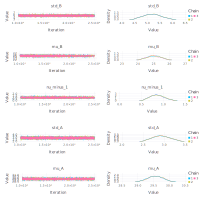

In [73]:
p = Mamba.plot(sim[:, :, :], legend = true)
Mamba.draw(p, nrow = 5, ncol = 2)

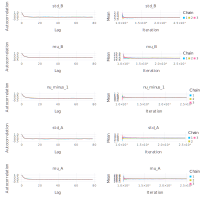

In [74]:
p = Mamba.plot(sim[:, :, :], [:autocor, :mean], legend = true)
Mamba.draw(p, nrow = 5, ncol = 2)

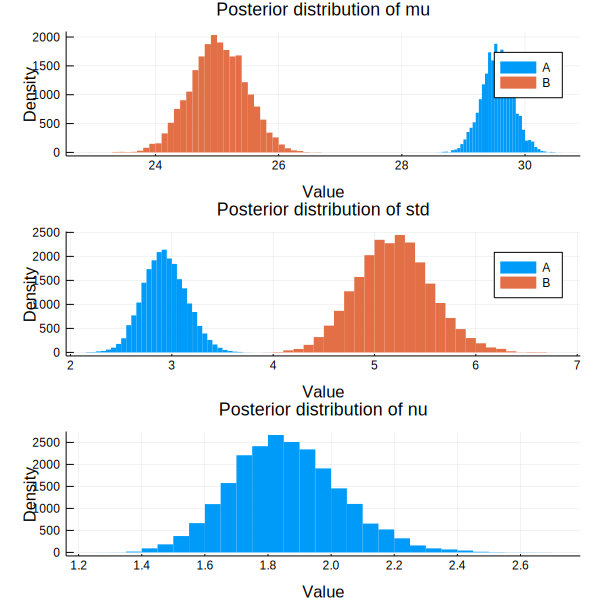

In [75]:
plt1 = Plots.plot()
histogram!(sim[:, [:mu_A], :].value[:], label = "A",
    bins = 50,
    title = "Posterior distribution of mu", titlefont = 12,
    xlabel = "Value", ylabel = "Density",
    linecolor = :transparent,
)
histogram!(sim[:, [:mu_B], :].value[:], label = "B",
    bins = 50,
    linecolor = :transparent,
)
plt2 = Plots.plot()
histogram!(sim[:, [:std_A], :].value[:], label = "A",
    bins = 50,
    title = "Posterior distribution of std", titlefont = 12,
    xlabel = "Value", ylabel = "Density",
    linecolor = :transparent,
)
histogram!(sim[:, [:std_B], :].value[:], label = "B",
    bins = 50,
    linecolor = :transparent,
)
plt3 = Plots.plot()
histogram!(sim[:, [:nu_minus_1], :].value[:] .+ 1, label = "",
    bins = 50,
    title = "Posterior distribution of nu", titlefont = 12,
    xlabel = "Value", ylabel = "Density",
    linecolor = :transparent,
)
Plots.plot(plt1, plt2, plt3, layout = (3, 1), size = [600, 600])

## 7.5 増加量の推定

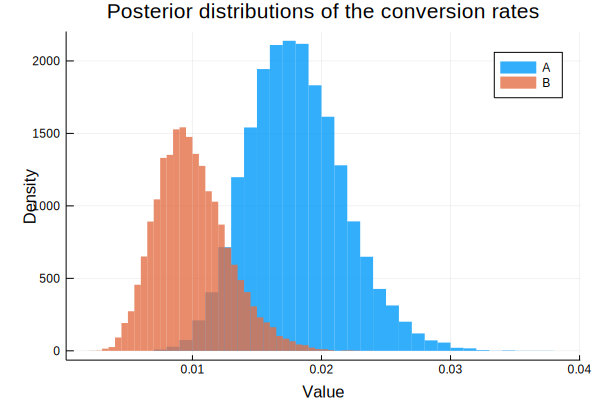

In [83]:
visitors_to_A = 1275
visitors_to_B = 1300

conversions_from_A = 22
conversions_from_B = 12

alpha_prior = 1
beta_prior = 1

posterior_A = Beta(alpha_prior + conversions_from_A, beta_prior + visitors_to_A - conversions_from_A)
posterior_B = Beta(alpha_prior + conversions_from_B, beta_prior + visitors_to_B - conversions_from_B)

samples = 20000
samples_posterior_A = rand(posterior_A, samples)
samples_posterior_B = rand(posterior_B, samples)

histogram(samples_posterior_A, xlabel = "Value", ylabel = "Density", 
    bins = 50, linewidth = 0, fillalpha = 0.8,
    title = "Posterior distributions of the conversion rates",
    label = "A")
histogram!(samples_posterior_B,
    bins = 50, linewidth = 0, fillalpha = 0.8,
    label = "B")

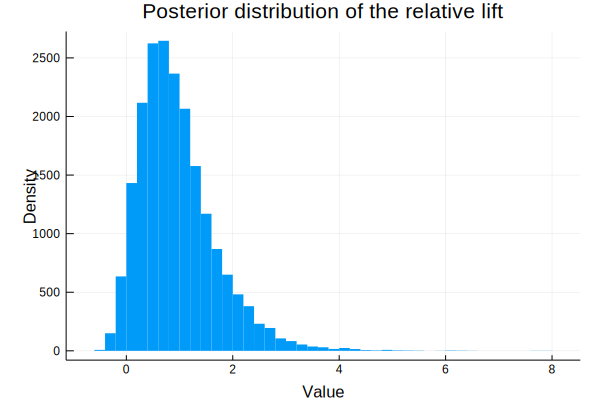

In [102]:
function relative_increase(a, b)
    (a - b) / b
end

posterior_rel_increase = relative_increase.(samples_posterior_A, samples_posterior_B)

histogram(posterior_rel_increase, bins = 50, linewidth = 0,
    xlabel = "Value", ylabel = "Density", label = "",
    title = "Posterior distribution of the relative lift")

In [88]:
println(mean(posterior_rel_increase .> 0.2))
println(mean(posterior_rel_increase .> 0.5))

0.88875
0.7177


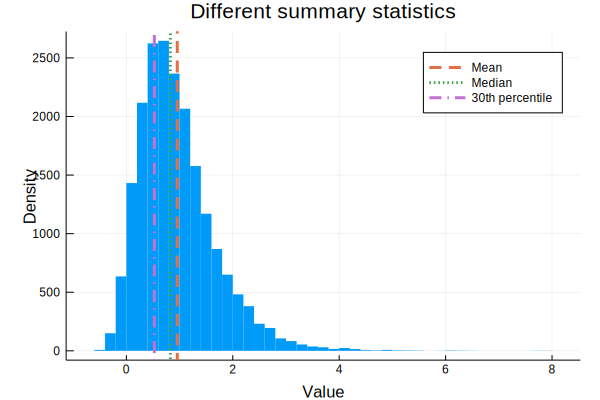

In [101]:
histogram(posterior_rel_increase, bins = 50, linewidth = 0,
    xlabel = "Value", ylabel = "Density", label = "",
    title = "Different summary statistics")
vline!([mean(posterior_rel_increase)], linewidth = 3, linestyle = :dash, label = "Mean")
vline!([median(posterior_rel_increase)], linewidth = 3, linestyle = :dot, label = "Median")
vline!([quantile(posterior_rel_increase, 0.3)], linewidth = 3, linestyle = :dashdot, label = "30th percentile")